<a href="https://colab.research.google.com/github/AliMadany/Deep-Learning-In-Computer-Vision-Models/blob/main/Image_Classification_using_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 5
The task is to build a cat versus dog image classifier using K-Nearest Neighbors (KNN) from
scratch. A filtered 2000 images subset of the CIFAR-100 dataset containing only "elephant"
and "bus" images) will be used for training and testing.  The implementation will involve
extracting image features by dividing each image into 4x4 blocks and calculating the mean
RGB color of each block, resulting in a 16x3-dimensional feature vector for each image.  The
core KNN algorithm will be implemented, including defining the Euclidean distance metric to
compare these feature vectors.  The implementation will involve searching the training set
for the k nearest neighbors to each test image based on these feature vectors and then using
a majority voting strategy among those neighbors to assign a class label (elephant/bus).  The
performance of the classifier will then be evaluated using accuracy as the metric.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Download and load CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


100%|██████████| 169M/169M [00:02<00:00, 61.1MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# class labels from CIFAR-100
cifar100_labels = cifar100_trainset.classes
print(cifar100_labels)

# indices for "elephant" and "bus"
elephant_idx = cifar100_labels.index("elephant")
bus_idx = cifar100_labels.index("bus")

print(f"Elephant Index: {elephant_idx}, Bus Index: {bus_idx}")


['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [ ]:
import numpy as np

def filter_dataset(dataset, class_indices):
    images, labels = [], []
    for img, label in dataset:
        if label in class_indices:
            images.append(img.numpy())  # tensor to NumPy array
            labels.append(label)

    return np.array(images), np.array(labels)

# images of elephants and buses
train_images, train_labels = filter_dataset(cifar100_trainset, [elephant_idx, bus_idx])
test_images, test_labels = filter_dataset(cifar100_testset, [elephant_idx, bus_idx])

print(f"Train set size: {len(train_images)}, Test set size: {len(test_images)}")


Train set size: 1000, Test set size: 200


In [ ]:
np.save("train_images.npy", train_images)
np.save("train_labels.npy", train_labels)
np.save("test_images.npy", test_images)
np.save("test_labels.npy", test_labels)

print("Filtered dataset saved!")



Filtered dataset saved!


In [ ]:
train_images = np.load("train_images.npy")
train_labels = np.load("train_labels.npy")
test_images = np.load("test_images.npy")
test_labels = np.load("test_labels.npy")

print("Filtered dataset loaded successfully!")


Filtered dataset loaded successfully!


In [ ]:
import numpy as np

# filtered dataset
train_labels = np.load("train_labels.npy")

# unique class labels
unique_classes = np.unique(train_labels)
print(f"Unique class labels in the filtered training set: {unique_classes}")


Unique class labels in the filtered training set: [13 31]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

# random indices
num_samples = 5
random_indices = random.sample(range(len(train_images)), num_samples)

# figure size
plt.figure(figsize=(10, 5))

for i, idx in enumerate(random_indices):
    #plt.subplot(1, num_samples, i + 1)

    # Convert (3, 32, 32) → (32, 32, 3)
    img = train_images[idx].transpose(1, 2, 0)

    # Resize image for better display
    img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_NEAREST)  # nearest neighbor scaling






<Figure size 1000x500 with 0 Axes>

In [ ]:
import numpy as np

def extract_features(images):
    """
    Extracts features from images by computing the mean RGB values in 4x4 blocks.

    Args:
        images (numpy array): Array of images with shape (num_samples, 3, 32, 32).

    Returns:
        numpy array: Feature vectors of shape (num_samples, 192).
    """
    num_samples = images.shape[0]
    feature_size = 192  # 64 blocks × 3 color channels = 192 features per image
    features = np.zeros((num_samples, feature_size))  # feature matrix

    for i, img in enumerate(images):
        img = np.transpose(img, (1, 2, 0))  # (3, 32, 32) → (32, 32, 3)
        blocks = []

        for row in range(0, 32, 4):
            for col in range(0, 32, 4):
                block = img[row:row+4, col:col+4]
                mean_rgb = np.mean(block, axis=(0, 1))  # mean RGB values
                blocks.extend(mean_rgb)  # Flatten feature vector

        features[i] = np.array(blocks)  # Store extracted features

    return features

# feature extraction
train_features = extract_features(train_images)
test_features = extract_features(test_images)
=
print("Train feature shape:", train_features.shape)
print("Test feature shape:", test_features.shape)


Train feature shape: (1000, 192)
Test feature shape: (200, 192)


In [ ]:
print("Train image shape:", train_images.shape)  # Expected: (num_samples, 32, 32, 3)


Train image shape: (1000, 3, 32, 32)


In [ ]:
import numpy as np

def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))


In [ ]:
import numpy as np
from collections import Counter

def knn_classify(test_sample, train_features, train_labels, k):

    distances = [np.linalg.norm(test_sample - train_features[i]) for i in range(len(train_features))]

    # indices of k nearest neighbors
    k_nearest_indices = np.argsort(distances)[:k]

    # labels of k nearest neighbors
    k_nearest_labels = [train_labels[i] for i in k_nearest_indices]

    # majority voting
    most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]

    return most_common_label

def compute_accuracy(predictions, actual_labels):
    return np.mean(np.array(predictions) == np.array(actual_labels)) * 100

# KNN on all test samples
k = 10
predicted_labels = [knn_classify(test_features[i], train_features, train_labels, k) for i in range(len(test_features))]

# accuracy
accuracy = compute_accuracy(predicted_labels, test_labels)
print(f"KNN Classifier Accuracy: {accuracy:.2f}%")


KNN Classifier Accuracy: 70.00%


KNN Classifier Accuracy on 50 samples: 70.00%


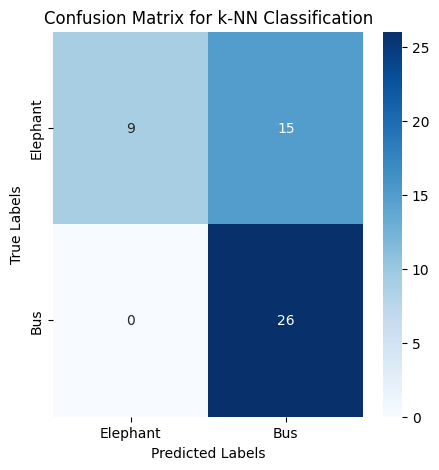

Classification Results (First 50 test samples):
Test Sample 1: True Label = 13, Predicted Label = 31
Test Sample 2: True Label = 13, Predicted Label = 13
Test Sample 3: True Label = 31, Predicted Label = 31
Test Sample 4: True Label = 31, Predicted Label = 31
Test Sample 5: True Label = 31, Predicted Label = 31
Test Sample 6: True Label = 31, Predicted Label = 31
Test Sample 7: True Label = 31, Predicted Label = 31
Test Sample 8: True Label = 31, Predicted Label = 31
Test Sample 9: True Label = 31, Predicted Label = 31
Test Sample 10: True Label = 13, Predicted Label = 31
Test Sample 11: True Label = 31, Predicted Label = 31
Test Sample 12: True Label = 13, Predicted Label = 31
Test Sample 13: True Label = 31, Predicted Label = 31
Test Sample 14: True Label = 13, Predicted Label = 31
Test Sample 15: True Label = 31, Predicted Label = 31
Test Sample 16: True Label = 13, Predicted Label = 31
Test Sample 17: True Label = 13, Predicted Label = 13
Test Sample 18: True Label = 13, Predicted 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def knn_classify(test_sample, train_features, train_labels, k):
    distances = [np.linalg.norm(test_sample - train_features[i]) for i in range(len(train_features))]
    k_nearest_indices = np.argsort(distances)[:k]
    k_nearest_labels = [train_labels[i] for i in k_nearest_indices]
    most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
    return most_common_label

# 50 test samples
k = 10
num_samples_to_classify = 50

test_samples = test_features[:num_samples_to_classify]
test_labels_subset = test_labels[:num_samples_to_classify]

predicted_labels = [knn_classify(test_samples[i], train_features, train_labels, k) for i in range(num_samples_to_classify)]

# accuracy
accuracy = np.mean(np.array(predicted_labels) == np.array(test_labels_subset)) * 100
print(f"KNN Classifier Accuracy on 50 samples: {accuracy:.2f}%")

# confusion matrix
conf_matrix = confusion_matrix(test_labels_subset, predicted_labels)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Elephant", "Bus"], yticklabels=["Elephant", "Bus"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for k-NN Classification")
plt.show()

# Display detailed classification results
print("Classification Results (First 50 test samples):")
for i in range(num_samples_to_classify):
    print(f"Test Sample {i+1}: True Label = {test_labels_subset[i]}, Predicted Label = {predicted_labels[i]}")
